### 라이브러리

In [37]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from xgboost import XGBClassifier
import xgboost as xgb

### 데이터 불러오기 

In [38]:
MY_PATH = '/content/drive/MyDrive'
train= pd.read_csv(MY_PATH + '/dacon프로젝트/소비자프로젝트/dataset/train.csv')
test=pd.read_csv(MY_PATH + '/dacon프로젝트/소비자프로젝트/dataset/test.csv')
sample_submission=pd.read_csv(MY_PATH + '/dacon프로젝트/소비자프로젝트/dataset/sample_submission.csv')

### 데이터 그래프

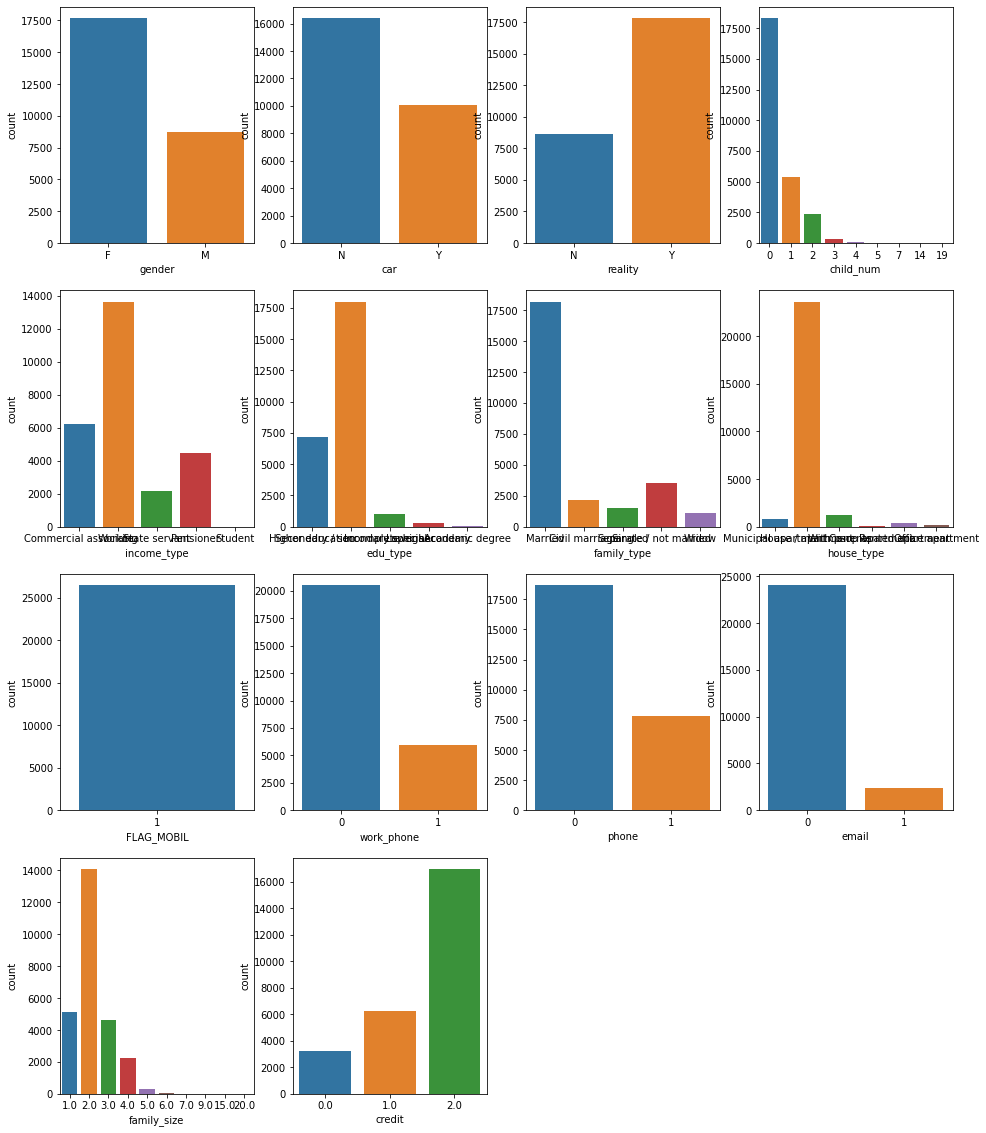

In [39]:
plt.figure(figsize=(16,20))
plt.subplot(4,4,1)
sns.countplot(data=train, x='gender')
plt.subplot(4,4,2)
sns.countplot(data=train, x='car')
plt.subplot(4,4,3)
sns.countplot(data=train, x='reality')
plt.subplot(4,4,4)
sns.countplot(data=train, x='child_num')
plt.subplot(4,4,5)
sns.countplot(data=train, x='income_type')
plt.subplot(4,4,6)
sns.countplot(data=train, x='edu_type')
plt.subplot(4,4,7)
sns.countplot(data=train, x='family_type')
plt.subplot(4,4,8)
sns.countplot(data=train, x='house_type')
plt.subplot(4,4,9)
sns.countplot(data=train, x='FLAG_MOBIL')
plt.subplot(4,4,10)
sns.countplot(data=train, x='work_phone')
plt.subplot(4,4,11)
sns.countplot(data=train, x='phone')
plt.subplot(4,4,12)
sns.countplot(data=train, x='email')
plt.subplot(4,4,13)
sns.countplot(data=train, x='family_size')
plt.subplot(4,4,14)
sns.countplot(data=train, x='credit')

### train_test 합치기(concat)

In [40]:
data= pd.concat([train, test], axis =0);data.head(3)

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0


### 변수 확인 및 1차 제거(index, family_size, flag)

In [41]:
unique_len = data.apply(lambda x : len(x.unique()));unique_len

index            36457
gender               2
car                  2
reality              2
child_num            9
income_total       265
income_type          5
edu_type             5
family_type          5
house_type           6
DAYS_BIRTH        7183
DAYS_EMPLOYED     3640
FLAG_MOBIL           1
work_phone           2
phone                2
email                2
occyp_type          19
family_size         10
begin_month         61
credit               4
dtype: int64

In [42]:
data = data.drop(['index','family_size','FLAG_MOBIL'], axis=1)

### 0,1 인코딩(1)

In [43]:
data['gender'] = data['gender'].replace(['F','M'],[0, 1])
data['car'] = data['car'].replace(['N','Y'],[0, 1])
data['reality'] = data['reality'].replace(['N','Y'],[0, 1])

### 0,1 인코딩(2) - occyp

In [44]:
data['occyp_type'].fillna(0,inplace=True)
data['occyp_type'].loc[(data['occyp_type'] == 0)]= 0
data['occyp_type'].loc[(data['occyp_type'] != 0)]= 1

In [45]:
# occyp가 object 형태이므로 labelencoding으로 float로 바꿔준다
label_encoder = LabelEncoder()
data['occyp_type'] = label_encoder.fit_transform(data['occyp_type'])
data['occyp_type'].value_counts()

1    25134
0    11323
Name: occyp_type, dtype: int64

### 레이블 인코딩 - 카테고리 3개 이상

In [46]:
label_encoder = LabelEncoder()

In [47]:
# child number
data.loc[data['child_num'] > 2, 'child_num'] = 2;data['child_num'].value_counts()

0    25201
1     7492
2     3764
Name: child_num, dtype: int64

In [48]:
# income_type
data['income_type'] = label_encoder.fit_transform(data['income_type'])
data['income_type'].value_counts()

4    18819
0     8490
1     6152
2     2985
3       11
Name: income_type, dtype: int64

In [49]:
# edu_type
data['edu_type'] = label_encoder.fit_transform(data['edu_type'])
data['edu_type'].value_counts()

4    24777
1     9864
2     1410
3      374
0       32
Name: edu_type, dtype: int64

In [50]:
# family_type
data['family_type'] = label_encoder.fit_transform(data['family_type'])
data['family_type'].value_counts()

1    25048
3     4829
0     2945
2     2103
4     1532
Name: family_type, dtype: int64

In [51]:
# house_type
data['house_type'] = label_encoder.fit_transform(data['house_type'])
data['house_type'].value_counts()

1    32548
5     1776
2     1128
4      575
3      262
0      168
Name: house_type, dtype: int64

### 정규화 전 CORR 확인

In [52]:
data.corr()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,begin_month,credit
gender,1.000000,0.361379,-0.050758,0.082905,0.197805,0.105639,0.005880,-0.099289,0.070301,0.202352,-0.173434,0.064994,-0.026833,-0.003284,0.152854,0.005079,0.001562
car,0.361379,1.000000,-0.015185,0.108653,0.215506,0.054817,-0.101272,-0.121716,0.016337,0.157144,-0.156452,0.021644,-0.014019,0.021750,0.118775,-0.029627,0.007761
reality,-0.050758,-0.015185,1.000000,-0.005346,0.032719,-0.046543,0.010997,0.022993,-0.179187,-0.129838,0.093006,-0.207732,-0.066601,0.052194,-0.054780,0.006476,-0.009387
child_num,0.082905,0.108653,-0.005346,1.000000,0.039223,0.110941,-0.060559,-0.172429,0.031028,0.361501,-0.243993,0.051692,-0.014736,0.020113,0.175118,-0.005181,0.003441
income_total,0.197805,0.215506,0.032719,0.039223,1.000000,-0.072974,-0.226931,-0.001191,-0.006480,0.067908,-0.168611,-0.037746,0.017245,0.086681,0.119265,-0.017494,0.008555
income_type,0.105639,0.054817,-0.046543,0.110941,-0.072974,1.000000,0.057225,-0.048532,0.035694,0.213509,-0.363363,0.165785,0.006529,-0.019567,0.243698,-0.000846,-0.008163
edu_type,0.005880,-0.101272,0.010997,-0.060559,-0.226931,0.057225,1.000000,0.007747,-0.036322,-0.169024,0.121874,-0.021092,-0.044875,-0.098457,-0.041260,0.014839,0.013780
family_type,-0.099289,-0.121716,0.022993,-0.172429,-0.001191,-0.048532,0.007747,1.000000,0.010025,-0.106486,0.120113,-0.063103,-0.015065,-0.010895,-0.079639,0.030053,-0.005230
house_type,0.070301,0.016337,-0.179187,0.031028,-0.006480,0.035694,-0.036322,0.010025,1.000000,0.211562,-0.107957,0.030080,-0.020254,0.012879,0.061358,0.030031,-0.009023
DAYS_BIRTH,0.202352,0.157144,-0.129838,0.361501,0.067908,0.213509,-0.169024,-0.106486,0.211562,1.000000,-0.616213,0.179054,-0.028659,0.105625,0.418938,0.053913,-0.025187


### 정규화

In [55]:
data[['DAYS_BIRTH','DAYS_EMPLOYED','income_total','begin_month']][:4]

,DAYS_BIRTH,DAYS_EMPLOYED,income_total,begin_month
0,-13899,-4709,202500.0,-6.0
1,-11380,-1540,247500.0,-5.0
2,-19087,-4434,450000.0,-22.0
3,-15088,-2092,202500.0,-37.0


In [56]:
# DAYS_BIRTH :양수 및 중위값 처리
data['DAYS_BIRTH'] = data['DAYS_BIRTH']* -1 ;data['DAYS_BIRTH'][:5]

0    13899
1    11380
2    19087
3    15088
4    15037
Name: DAYS_BIRTH, dtype: int64

In [57]:
# DAYS_EMPLOYED : 이상값 중위수 처리
data.sort_values(by='DAYS_EMPLOYED',ascending =False)
indexs = data[data['DAYS_EMPLOYED']==365243].index
data_employed = data[data['DAYS_EMPLOYED'] != 365243]

# 이상값 중위수 처리
median_employed = data_employed['DAYS_EMPLOYED'].median()

# 양수 변환
data['DAYS_EMPLOYED']=data['DAYS_EMPLOYED'].replace(365243, median_employed)
data['DAYS_EMPLOYED']=data['DAYS_EMPLOYED'] * -1

In [58]:
# begin_month : 양수 변환
data['begin_month']=data['begin_month'] * -1

### 4개 변수 정규화

In [59]:
data['DAYS_BIRTH'] = (data['DAYS_BIRTH'] - data['DAYS_BIRTH'].mean()) / data['DAYS_BIRTH'].std()
data['DAYS_EMPLOYED'] = (data['DAYS_EMPLOYED'] - data['DAYS_EMPLOYED'].mean()) / data['DAYS_EMPLOYED'].std()
data['income_total'] = (data['income_total'] - data['income_total'].mean()) / data['income_total'].std()
data['begin_month'] = (data['begin_month'] - data['begin_month'].mean()) / data['begin_month'].std()

In [60]:
data[['DAYS_BIRTH','DAYS_EMPLOYED','income_total','begin_month']][:4]

,DAYS_BIRTH,DAYS_EMPLOYED,income_total,begin_month
0,-0.494262,1.004480,0.155363,-1.221935
1,-1.093946,-0.460090,0.597453,-1.282534
2,0.740814,0.877387,2.586858,-0.252347
3,-0.211204,-0.204981,0.155363,0.656642


### 전처리 데이터 최종 CORR 확인

In [61]:
data.corr()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,begin_month,credit
gender,1.000000,0.361379,-0.050758,0.082905,0.197805,0.105639,0.005880,-0.099289,0.070301,-0.202352,-0.095072,0.064994,-0.026833,-0.003284,0.152854,-0.005079,0.001562
car,0.361379,1.000000,-0.015185,0.108653,0.215506,0.054817,-0.101272,-0.121716,0.016337,-0.157144,-0.047415,0.021644,-0.014019,0.021750,0.118775,0.029627,0.007761
reality,-0.050758,-0.015185,1.000000,-0.005346,0.032719,-0.046543,0.010997,0.022993,-0.179187,0.129838,-0.004734,-0.207732,-0.066601,0.052194,-0.054780,-0.006476,-0.009387
child_num,0.082905,0.108653,-0.005346,1.000000,0.039223,0.110941,-0.060559,-0.172429,0.031028,-0.361501,-0.035149,0.051692,-0.014736,0.020113,0.175118,0.005181,0.003441
income_total,0.197805,0.215506,0.032719,0.039223,1.000000,-0.072974,-0.226931,-0.001191,-0.006480,-0.067908,0.037324,-0.037746,0.017245,0.086681,0.119265,0.017494,0.008555
income_type,0.105639,0.054817,-0.046543,0.110941,-0.072974,1.000000,0.057225,-0.048532,0.035694,-0.213509,0.086133,0.165785,0.006529,-0.019567,0.243698,0.000846,-0.008163
edu_type,0.005880,-0.101272,0.010997,-0.060559,-0.226931,0.057225,1.000000,0.007747,-0.036322,0.169024,0.024306,-0.021092,-0.044875,-0.098457,-0.041260,-0.014839,0.013780
family_type,-0.099289,-0.121716,0.022993,-0.172429,-0.001191,-0.048532,0.007747,1.000000,0.010025,0.106486,-0.013287,-0.063103,-0.015065,-0.010895,-0.079639,-0.030053,-0.005230
house_type,0.070301,0.016337,-0.179187,0.031028,-0.006480,0.035694,-0.036322,0.010025,1.000000,-0.211562,-0.061400,0.030080,-0.020254,0.012879,0.061358,-0.030031,-0.009023
DAYS_BIRTH,-0.202352,-0.157144,0.129838,-0.361501,-0.067908,-0.213509,0.169024,0.106486,-0.211562,1.000000,0.187958,-0.179054,0.028659,-0.105625,-0.418938,0.053913,0.025187


### 데이터분리

In [62]:
train = data[:-10000]
test = data[-10000:]

In [63]:
train_x = train.drop('credit',axis=1)
train_y=train['credit']
test_x = test.drop('credit', axis = 1)
print(train_x.shape, train_y.shape, test_x.shape)

(26457, 16) (26457,) (10000, 16)


### XGBOOST

In [88]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size = 0.1, random_state = 33)
dtrain = xgb.DMatrix(data = X_train, label = y_train)
dtest = xgb.DMatrix(data = X_val, label = y_val)
print(X_train.shape,y_train.shape,X_val.shape, y_val.shape)

(23811, 16) (23811,) (2646, 16) (2646,)


### 하이퍼 파라미터

In [104]:
params = {
    'max_depth' : 10,
    'eta' : 0.1,
    'subsample' : 0.9,
    'gamma' : 0.01,
    'lambda' : 0.01,
    'objective' : 'multi:softprob',
    'num_class' : 3,
    'eval_metric' : 'mlogloss'
}
num_rounds=1000

### xgboost 실행(50개씩 출력)

In [105]:
evals = [(dtrain,'train'),(dtest,'eval')]
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds,
                     early_stopping_rounds=50, verbose_eval=50, evals=evals)

[0]	train-mlogloss:1.0475	eval-mlogloss:1.05358
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 50 rounds.
[50]	train-mlogloss:0.588356	eval-mlogloss:0.745583
[100]	train-mlogloss:0.474495	eval-mlogloss:0.723537
[150]	train-mlogloss:0.395717	eval-mlogloss:0.715803
[200]	train-mlogloss:0.33873	eval-mlogloss:0.714359
Stopping. Best iteration:
[193]	train-mlogloss:0.345973	eval-mlogloss:0.713192



### 예측확률 행렬 출력

In [67]:
dtestx = xgb.DMatrix(data = test_x)
pred_probs = xgb_model.predict(dtestx);pred_probs[:10]

array([[7.79951289e-02, 7.40444437e-02, 8.47960413e-01],
       [9.37842950e-02, 1.67353958e-01, 7.38861799e-01],
       [1.66605208e-02, 3.59625891e-02, 9.47376847e-01],
       [1.20117821e-01, 1.40681386e-01, 7.39200771e-01],
       [9.01856720e-02, 1.05926745e-01, 8.03887606e-01],
       [5.28101660e-02, 1.04890451e-01, 8.42299402e-01],
       [4.52029526e-01, 5.47487020e-01, 4.83421289e-04],
       [5.57603650e-02, 8.64767432e-02, 8.57762873e-01],
       [4.92376164e-02, 1.17926568e-01, 8.32835793e-01],
       [2.00577285e-02, 2.61565864e-01, 7.18376458e-01]], dtype=float32)

### sample_submission 데이터 넣기 및 csv 생성

In [68]:
sample_submission.iloc[:,1:] = pred_probs;sample_submission

,index,0,1,2
0,26457,0.077995,0.074044,0.847960
1,26458,0.093784,0.167354,0.738862
2,26459,0.016661,0.035963,0.947377
3,26460,0.120118,0.140681,0.739201
4,26461,0.090186,0.105927,0.803888
...,...,...,...,...
9995,36452,0.101402,0.168245,0.730353
9996,36453,0.190881,0.426970,0.382149
9997,36454,0.011064,0.033863,0.955073
9998,36455,0.084888,0.406913,0.508199


In [106]:
sample_submission.to_csv("xgboost516_1.csv", index= False)